<a href="https://colab.research.google.com/github/Antoniopv7/Mineria-Prueba2/blob/main/Evaluacion_2_Mineria_de_datos_FINAL%20CON%20LAS%20TRANSFORMACIONES%20XD%20ME%20QUIERO%20MATAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Importar librerías
import pandas as pd
import urllib.request
import zipfile
import tempfile
import numpy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [32]:
# 1. Descargar la encuesta CASEN 2022
STATA_zip_url = 'https://observatorio.ministeriodesarrollosocial.gob.cl/storage/docs/casen/2022/Base%20de%20datos%20Casen%202022%20STATA_18%20marzo%202024.dta.zip'
STATA_file_name = 'Base de datos Casen 2022 STATA_18 marzo 2024.dta'

STATA_temp_file = tempfile.NamedTemporaryFile(delete=False)
STATA_zip_name = STATA_temp_file.name
urllib.request.urlretrieve(STATA_zip_url, STATA_zip_name)
with zipfile.ZipFile(STATA_zip_name, 'r') as zip_ref:
    zip_ref.extract(STATA_file_name)

data_STATA = pd.read_stata(STATA_file_name, convert_categoricals=False)

<ipython-input-32-46b2724262f0>:11: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  data_STATA = pd.read_stata(STATA_file_name, convert_categoricals=False)


In [33]:
# 5. Realice una limpieza de los datos, eliminando valores nulos y outliers
data_STATA_cleaned = data_STATA.dropna(subset=['ytrabajocor'])
data_STATA_cleaned = data_STATA_cleaned.apply(pd.to_numeric, errors='coerce')
data_STATA_cleaned = data_STATA_cleaned.dropna(thresh=0.5 * len(data_STATA_cleaned), axis=1)
data_STATA_cleaned = data_STATA_cleaned.fillna(data_STATA_cleaned.mean())

In [34]:
# Función para aplicar transformaciones
def apply_transformations(data):
    transformed_data = data.copy()
    for column in transformed_data.columns:
        if transformed_data[column].min() > 0:  # Aplicar transformaciones solo si no hay valores no positivos
            transformed_data[column + '_log'] = np.log(transformed_data[column])
            transformed_data[column + '_sqrt'] = np.sqrt(transformed_data[column])
    return transformed_data

data_STATA_transformed = apply_transformations(data_STATA_cleaned)

<ipython-input-34-18c6e2f0f9ed>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed_data[column + '_sqrt'] = np.sqrt(transformed_data[column])
<ipython-input-34-18c6e2f0f9ed>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed_data[column + '_log'] = np.log(transformed_data[column])
<ipython-input-34-18c6e2f0f9ed>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

In [35]:
scaler = MinMaxScaler()
data_STATA_transformed_normalized = pd.DataFrame(scaler.fit_transform(data_STATA_transformed), columns=data_STATA_transformed.columns)

In [36]:
# 4. Seleccione al menos 8 variables importantes para su modelo y explicando claramente su significado
X = data_STATA_transformed_normalized.drop('ytrabajocor', axis=1)
y = data_STATA_transformed_normalized['ytrabajocor']
rfe = RFE(estimator=LinearRegression(), n_features_to_select=8)
X_rfe = rfe.fit_transform(X, y)
columnas_seleccionadas = X.columns[rfe.get_support()]
print("Variables seleccionadas:", columnas_seleccionadas)

Variables seleccionadas: Index(['id_vivienda', 'folio', 'fecha_entrev', 'id_vivienda_log',
       'id_vivienda_sqrt', 'folio_log', 'folio_sqrt', 'fecha_entrev_sqrt'],
      dtype='object')


<Figure size 1200x1000 with 0 Axes>

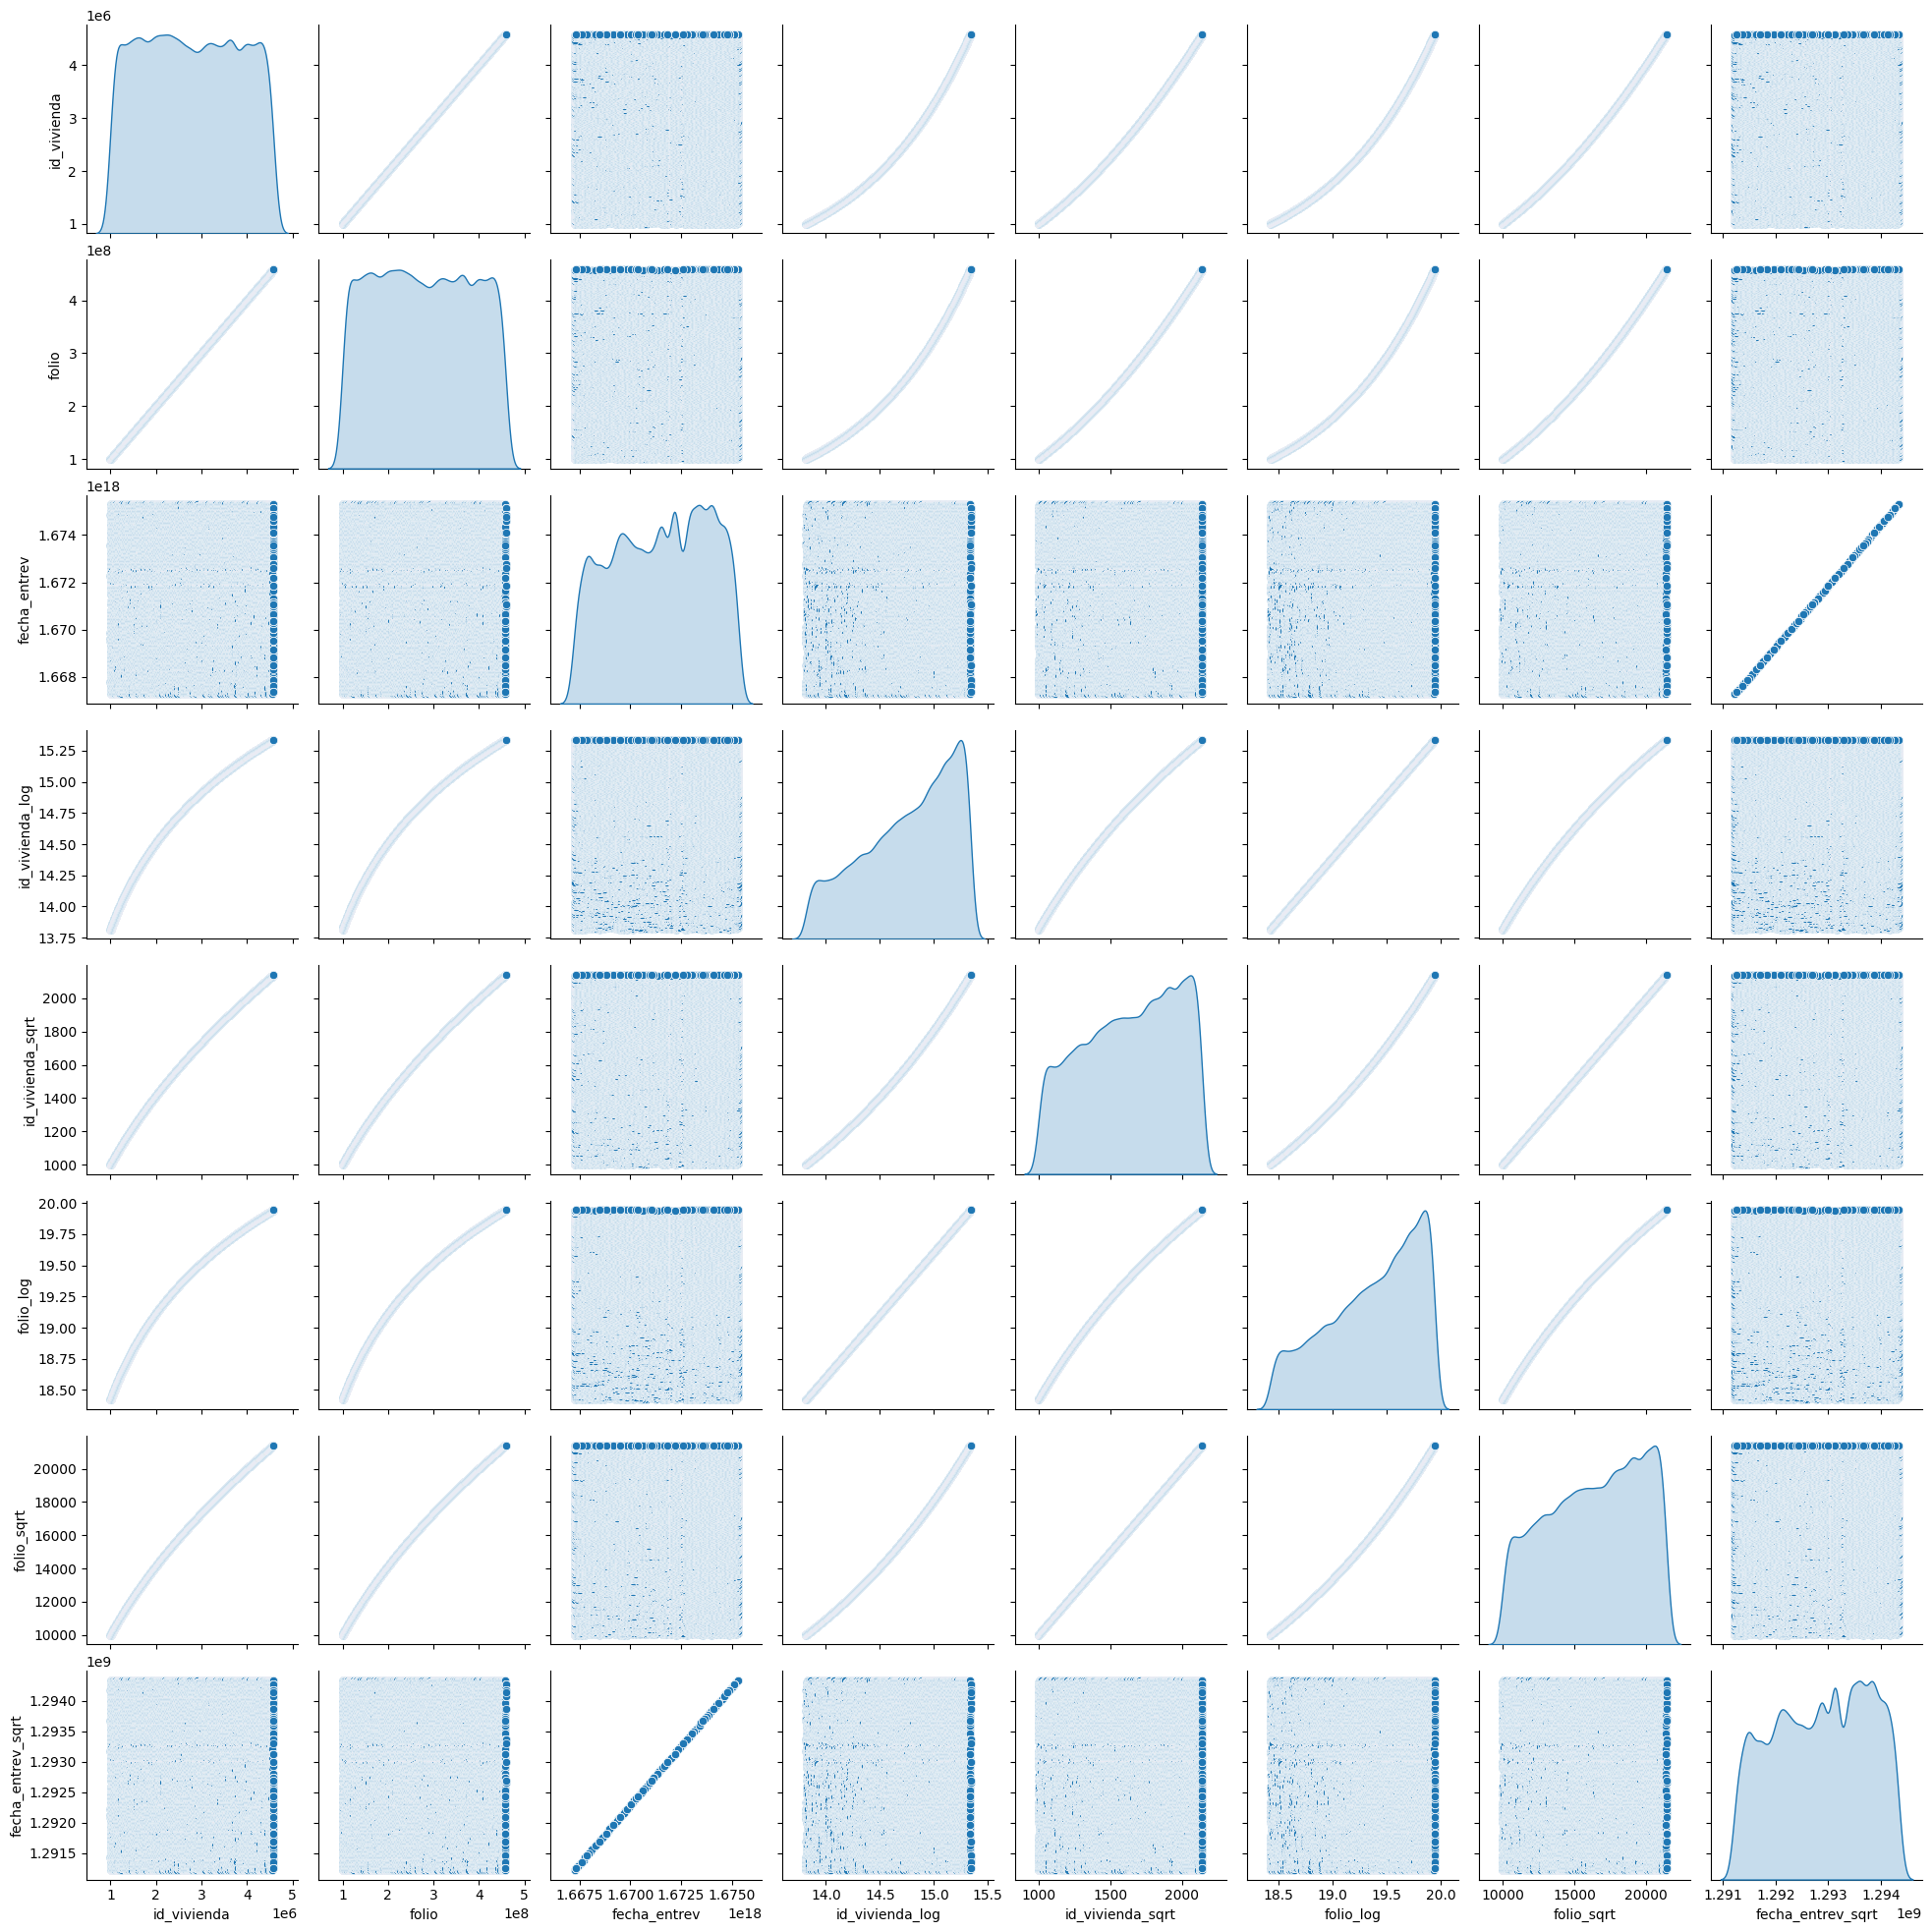

In [38]:
# 6. Realice un análisis descriptivo, mostrando al menos los gráficos de dispersión, histogramas, gráficos de torta, caja, etc.
# Análisis descriptivo de las variables seleccionadas
plt.figure(figsize=(12, 10))
sns.pairplot(data_STATA_transformed[columnas_seleccionadas], diag_kind='kde')
plt.show()

In [39]:
# 7. Obtenga el mejor ajuste posible con al menos un R^2 igual a 0.7
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2:.2f}")

R^2: 0.01


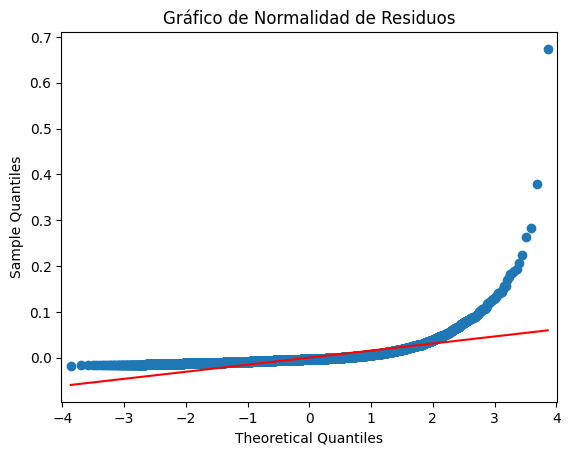

In [40]:
# 8. Compruebe que su modelo satisface las condiciones de regresión lineal múltiple (Hipótesis de Normalidad)
residuos = y_test - y_pred
sm.qqplot(residuos, line='s')
plt.title("Gráfico de Normalidad de Residuos")
plt.show()

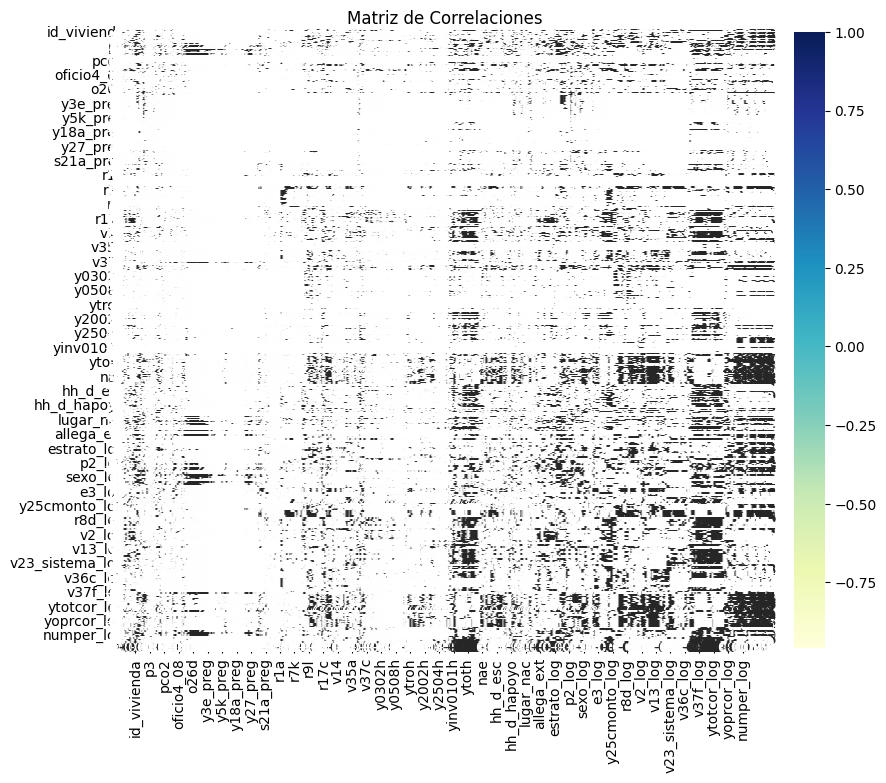

In [41]:
# 9. Calcule la matriz de correlaciones entre las variables e interprete, realice el gráfico de correlaciones entre los pares de variables
correlation_matrix = data_STATA_transformed_normalized.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title("Matriz de Correlaciones")
plt.show()

In [42]:
# 10. Represente el modelo de regresión lineal múltiple interpretando y explicando la importancia de cada uno de los coeficientes betas
coef = pd.Series(model.coef_, index=X.columns[rfe.get_support()])
print("Coeficientes del modelo:")
print(coef)

Coeficientes del modelo:
id_vivienda         -2.934982e+06
folio                2.934982e+06
fecha_entrev         1.152559e+01
id_vivienda_log     -2.876521e+06
id_vivienda_sqrt     6.458297e+06
folio_log            2.876521e+06
folio_sqrt          -6.458297e+06
fecha_entrev_sqrt   -1.152163e+01
dtype: float64


In [43]:
# 11. Calcule al menos 2 índices de error de la RLM
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

Error cuadrático medio (MSE): 0.0002376450204030672
Raíz del error cuadrático medio (RMSE): 0.015415739372572021


In [44]:
import numpy as np

# 12. Realice una predicción basado en su modelo
nuevos_datos_sin_normalizar = pd.DataFrame(columns=data_STATA_transformed.columns)

print("Número de columnas en data_STATA_cleaned:", len(data_STATA_transformed.columns))

num_columnas = len(data_STATA_transformed.columns)
valores_aleatorios = list(np.random.random(num_columnas))

nuevos_datos_sin_normalizar.loc[0] = valores_aleatorios

nuevos_datos_normalizados = pd.DataFrame(scaler.transform(nuevos_datos_sin_normalizar), columns=nuevos_datos_sin_normalizar.columns)
nuevos_datos_prediccion = nuevos_datos_normalizados[X.columns[rfe.get_support()]]
predicciones = model.predict(nuevos_datos_prediccion)
print("Predicciones:", predicciones)

Número de columnas en data_STATA_cleaned: 686
Predicciones: [-9769694.85272637]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


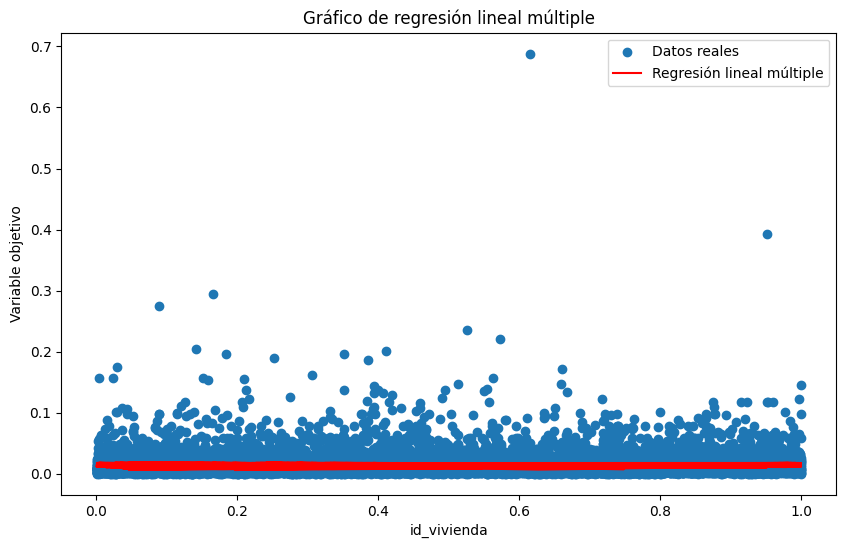

In [45]:
# 13. Realice un gráfico de la recta de RLM sobre los datos
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], y_test, label='Datos reales')
plt.plot(X_test[:, 0], y_pred, color='red', label='Regresión lineal múltiple')
plt.xlabel(X.columns[rfe.get_support()][0])  # Accede al nombre de la columna desde X.columns
plt.ylabel('Variable objetivo')
plt.title('Gráfico de regresión lineal múltiple')
plt.legend()
plt.show()

In [46]:
# 15. Discuta cómo se podría mejorar este modelo
print("Posibles mejoras del modelo:")
print("- Explorar transformaciones de variables para mejorar la linealidad")
print("- Considerar modelos no lineales (ej. regresión polinomial, árboles de decisión)")
print("- Realizar una validación cruzada para una mejor estimación del rendimiento")
print("- Ajustar los hiperparámetros del modelo (ej. regularización)")
print("- Probar técnicas de ensemble (ej. Random Forest, Gradient Boosting)")

Posibles mejoras del modelo:
- Explorar transformaciones de variables para mejorar la linealidad
- Considerar modelos no lineales (ej. regresión polinomial, árboles de decisión)
- Realizar una validación cruzada para una mejor estimación del rendimiento
- Ajustar los hiperparámetros del modelo (ej. regularización)
- Probar técnicas de ensemble (ej. Random Forest, Gradient Boosting)
